In [7]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
np.random.seed(42)  # Ensure reproducibility

### A-SOM class to represent Layers with

In [8]:
"""
    A class to represent an Aligned Self-Organizing Map (SOM).
    Attributes:
    -----------
    m : int
        Number of rows in the SOM grid.
    n : int
        Number of columns in the SOM grid.
    dim : int
        Dimensionality of the input data.
    layer : int, optional
        Layer index of the SOM (default is 0).
    n_iterations : int, optional
        Number of iterations for training (default is 100).
    alpha : float, optional
        Initial learning rate.
    sigma : float, optional
        Initial neighborhood radius.
    p_values : np.ndarray, optional
        Scaling factors for input dimensions (default is np.ones(dim)).
    trained : bool
        Indicates whether the SOM has been trained.
    weightages : np.ndarray
        Weights of the SOM nodes.
    deltas : np.ndarray
        Changes in weights during last training iteration.
    locations : np.ndarray
        Locations of the SOM nodes in the grid.
    """
class AlignedSOM:

    def __init__(self, n, m, dim, layer=0, n_iterations=100, alpha=None, sigma=None, p_values=None):
        # size of the SOM
        self.m = m 
        self.n = n
        # Dimentions of the input data
        self.dim = dim
        # Number of layers
        self.layer = layer
        #Number of iterations for the training process
        self.n_iterations = n_iterations
        #Initial learning rate
        self.alpha = alpha if alpha else 0.3
        #Initial neighbourhood radius
        self.sigma = sigma if sigma else max(m, n) / 2.0
        # Indicated whether the SOM (layer) is trained
        self.trained = False
        # Weights
        self.weightages = None
        # P-values
        self.p_values = p_values if p_values is not None else np.ones(dim)
        # Delta values
        self.deltas = np.zeros((m * n, dim))
        # Neurons
        self.locations = np.array([np.array([i, j]) for i in range(m) for j in range(n)])

    """
    Inializes the weights of a SOM
    """
    def initialize_weights(self, shared_weights):
        self.weightages = shared_weights

    """
    Finds the Best Matching Unit (BMU) for a given input vector.
    """
    def find_bmu(self, input_vect):
        # Scale input vector with p-values, thus regulating which features have more importance in the current layer
        scaled_input = input_vect * self.p_values
        scaled_weights = self.weightages * self.p_values
        distances = np.linalg.norm(scaled_weights - scaled_input, axis=1)
        return np.argmin(distances)
    """
    Trains the SOM with a given input vector for a specific iteration.
    The number of the iteration is used to update the learning rate and neighborhood radius.
    """
    def train(self, input_vect, iter_no):
        bmu_index = self.find_bmu(input_vect)
        bmu_location = self.locations[bmu_index]

        # Update learning rate and neighborhood radius
        learning_rate = self.alpha * (1 - iter_no / self.n_iterations)
        neighborhood_radius = self.sigma * (1 - iter_no / self.n_iterations)

        # Update weights of nodes in the neighborhood of the BMU
        for i, location in enumerate(self.locations):
            distance_to_bmu = np.linalg.norm(location - bmu_location)
            if distance_to_bmu <= neighborhood_radius:
                influence = np.exp(-distance_to_bmu ** 2 / (2 * (neighborhood_radius ** 2)))
                delta = learning_rate * influence * (input_vect - self.weightages[i])
                self.weightages[i] += delta
                self.deltas[i] = delta

        # Sets the SOM as trained
        self.trained = True

    """
    Aligns the SOM weights with given deltas(of another layer) and decay factor
    """
    def align(self, deltas, decay):
        self.weightages += deltas * decay

    """
    Maps input vectors to their corresponding BMUs in the SOM grid.
    Used for visualizing the mappings of input data on the SOM grid.
    """
    def map_vects(self, input_vects):
        if not self.trained:
            raise ValueError("SOM not trained yet")

        mapped = []
        for vect in input_vects:
            bmu_index = self.find_bmu(vect)
            mapped.append(self.locations[bmu_index])
        return mapped

"""
    Aligns the layers of the SOM based on the current layer's deltas.
    Parameters:
    -----------
    current_layer : AlignedSOM
        The current layer being trained.
    layers : list of AlignedSOM
        List of all SOM layers.
    coef : float, optional
        Coefficient for decay calculation (default is 1.0).
"""
def align_layers(current_layer, layers, coef=1.0):
    for layer in layers:
        if layer != current_layer:
            decay = coef * (2 ** (-abs(current_layer.layer - layer.layer)))
            layer.align(current_layer.deltas, decay)


#### Helper functions for the main training procedure

In [9]:
"""
    Initializes p-values for scaling input dimensions.
    Does an interpolation, similar as the one shown in (E.Pampalk, 2003)
    Parameters:
    -----------
    dim : int
        Dimensionality of the input data.
    Returns:
    --------
    tuple of np.ndarray
        Two arrays of p-values for the input dimensions.
"""
def init_p_values(dim):
    p0_values = np.zeros(dim, dtype=int)
    p1_values = np.zeros(dim, dtype=int)
    if dim == 1:
        p0_values[0] = 1
        p1_values[0] = 1
    elif dim == 2:
        p0_values[0] = 1
        p1_values[1] = 1
    else:
        p0_values[0] = 1
        p1_values[dim-1] = 1
        p0_values[dim//2] = 1
        p1_values[dim//2] = 1
        for i in range(1, dim//2 + 1):
            p0_values[i] = 1 + (dim//2 - i)
            p1_values[i] = 1
        for i in range(dim//2 + 1, dim - 1):
            p0_values[i] = 1
            p1_values[i] = 1 + (i - dim//2)
    return p0_values, p1_values

"""
    Gets the p-values for a specific layer.
    Parameters:
    -----------
    layer : int
        Layer index.
    p0_values : np.ndarray
        Array of p0 values.
    p1_values : np.ndarray
        Array of p1 values.
    p0_indices : list of int
        Indices for p0 values.
    p1_indices : list of int
        Indices for p1 values.
    Returns:
    --------
    np.ndarray
        Array of p-values for the specified layer.
    """
def get_p_values_for_layer(layer, dim, p0_values, p1_values, p0_indices, p1_indices):
    p_values = np.zeros(dim)
    p_values[p0_indices] = p0_values[layer]
    p_values[p1_indices] = p1_values[layer]
    return p_values



### MAIN TRAINING PROCEDURE

In [10]:


"""
    Trains an Aligned Self-Organizing Map (ASOM) with the given data.
    Parameters:
    -----------
    data : np.ndarray
        Input data for training.
    m : int
        Number of rows in the SOM grid.
    n : int
        Number of columns in the SOM grid.
    dim : int
        Dimensionality of the input data.
    layers : int
        Number of SOM layers.
    iterations : int
        Number of iterations for training.
    p0_values : np.ndarray
        Array of p0 values for scaling input dimensions.
    p1_values : np.ndarray
        Array of p1 values for scaling input dimensions.
    p0_indices : list of int
        Indices for p0 values.
    p1_indices : list of int
        Indices for p1 values.
    alpha : float, optional
        Initial learning rate.
    sigma : float, optional
        Initial neighborhood radius.
    alignment_coef : float, optional
        Coefficient for alignment decay (default is 1.0).
    Returns:
    --------
    list of AlignedSOM
        List of trained SOM layers.
    """
def train_ASOM(data, n, m, dim, layers, iterations, p0_indices, p1_indices, alpha=None, sigma=None, alignment_coef = 1.0):
    shared_weights = np.random.normal(size=(n*m, dim))
    p0_values, p1_values = init_p_values(layers)
    layers = [AlignedSOM(n, m, dim, layer=i, n_iterations=iterations, p_values=get_p_values_for_layer(i, dim, p0_values, p1_values, p0_indices, p1_indices), alpha=alpha, sigma=sigma) for i in range(layers)]
    for layer in layers:
        layer.initialize_weights(shared_weights.copy())

    for iteration in range(iterations):
        current_layer = np.random.choice(layers)
        current_data_point = np.random.choice(len(data))
        current_layer.train(data[current_data_point], iteration)
        align_layers(current_layer, layers, alignment_coef)
    return layers


### VISUALIZE ALL LAYERS

In [11]:
"""
    Visualizes the mappings of input data on the SOM layers.
    Parameters:
    -----------
    layers : list of AlignedSOM
        List of trained SOM layers.
    data : np.ndarray
        Input data to be mapped.
    data_names : list of str, optional
        Names of the input data points (default is None).
    """
def visualize_ASOM_layers(layers, data, data_names=None):
    for layer_index, layer in enumerate(layers):
        mapping = layer.map_vects(data)
        plt.figure()
        plt.title(f"Layer {layer_index} Mapping")
        for i, loc in enumerate(mapping):
            plt.text(loc[0], loc[1], data_names[i] if data_names is not None else i, ha='center', va='center')
        plt.xlim(-1, layer.m + 1)
        plt.ylim(-1, layer.n + 1)
        plt.gca().invert_yaxis()
        plt.show()


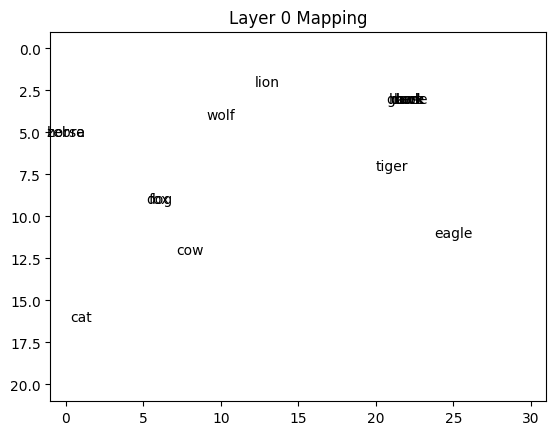

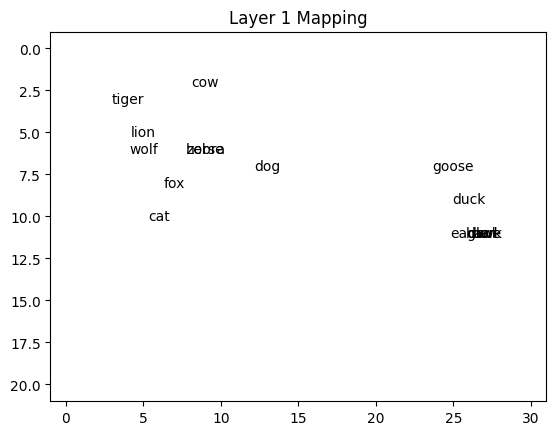

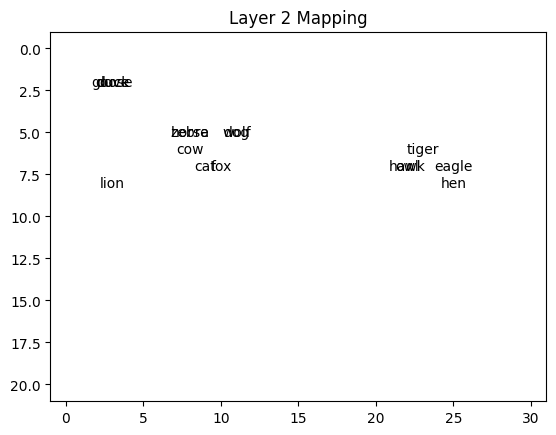

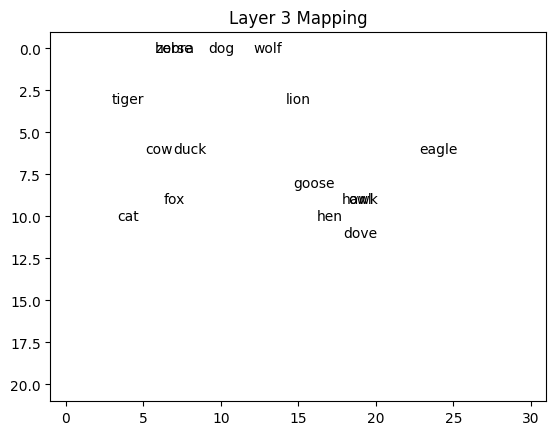

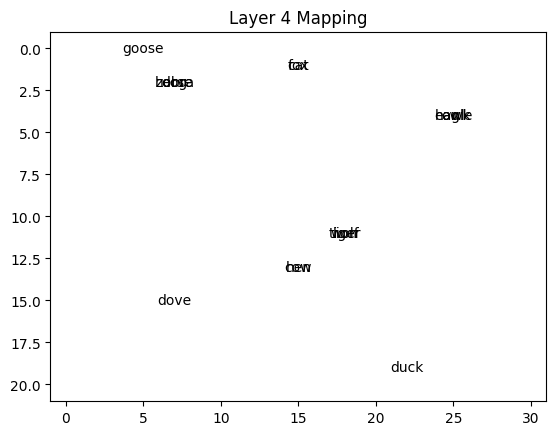

In [12]:
animals = np.array(
    [[1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
     [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
     [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
     [1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.],
     [1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.],
     [0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.],
     [0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.],
     [0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
     [0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.],
     [1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.],
     [0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.],
     [0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.],
     [0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.],
     [0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.]])
animals_names = ['dove', 'hen', 'duck', 'goose', 'owl', 'hawk', 'eagle', 'fox',
                 'dog', 'wolf', 'cat', 'tiger', 'lion', 'horse', 'zebra', 'cow']


# Shared initialization
dim = 13
layers = 5
n = 20
m = 30
p0_indices = [i for i in range(9)]
p1_indices = [i for i in range(9, 13)]
iterations = 200
lrm = 0.3



layers = train_ASOM(
    data = animals,
    n=n,
    m=m,
    dim= dim,
    layers= layers,
    iterations= iterations, 
    p0_indices = p0_indices, 
    p1_indices=p1_indices,
    alpha=lrm
     )
visualize_ASOM_layers(layers, animals, animals_names)